# Cuaderno de exploración de los modelos ARIMA
Como funcionan, adicionalmente explroación de las librerias statsmodels y pmdarima, esto teniendo en cuenta las problematicas del computo actual de los modelos SARIMA para imputar datos entrenando sobre series de tiempo con datos nulos en su interior. Asi que se prueban diferentres tecnicas para imputar, llenando con la media de cada mes, generando valores a partir de la distribucion de los datos y eliminando los datos, posteriormente se realiza el entrenamiento de los modelos SARIMA y finalmente un analisis de la metrica RMSE y se seleeciona el mejor modelo.

Empezamos revisando la cantidad de valores nulos que tenemos en un dataframe cualquiera, en este caso, tomamos 3 valores al azar entre la cantidad total de estaciones.

In [2]:
! pip install matplotlib
! pip install seaborn

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     -------------------------------------- 165.5/165.5 kB 3.3 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 10.9 MB/s eta 0:00:01
   ----- ---------------------------------- 1.1/8.0 MB 11.2 MB/s eta 0:00:01
   ------- -------------------------------- 1.5/8.0 MB 10.5 MB/s eta 0:00:01
   --------- ------------------------------ 2.0/8.0 MB 10.5 MB/s eta 0:00:01
   ------------ --------------------------- 2.5/8.0 MB 10.6 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.0 MB 10.4 MB/s eta 0:00:01
   ----------------- ---------------------- 3.5/8.0 MB 10.6 MB/s eta 0:00:01
   -------------------- ------------------- 4.0/8.0 MB 11.2 MB/s eta 0:00:01
   ----------------------- -----

In [11]:
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Cargamos los datos
path = '../datos/separados_por_estacion/MAGDALENA_MEDIO/'

# Generamos un entero aletorio entre la cantidad total de estaciones
count_stations = os.listdir(path)

np.random.seed(1)
files = np.random.choice(count_stations, 3, replace=False)

stations = [s.split('.')[0] for s in files]
dfs = [pd.read_csv(path+file) for file in files]


for df, station in zip(dfs, stations):
    col_null = df.columns[df.isnull().any()].tolist()
    print(f'Cantidad de valores nulos en {station}:',df[col_null].isnull().sum())

Cantidad de valores nulos en 23145020: 23145020    3
dtype: int64
Cantidad de valores nulos en 23080820: 23080820    47
dtype: int64
Cantidad de valores nulos en 23105030: 23105030    5
dtype: int64


Empezamos revisando si la series de tiempo son estacionarias

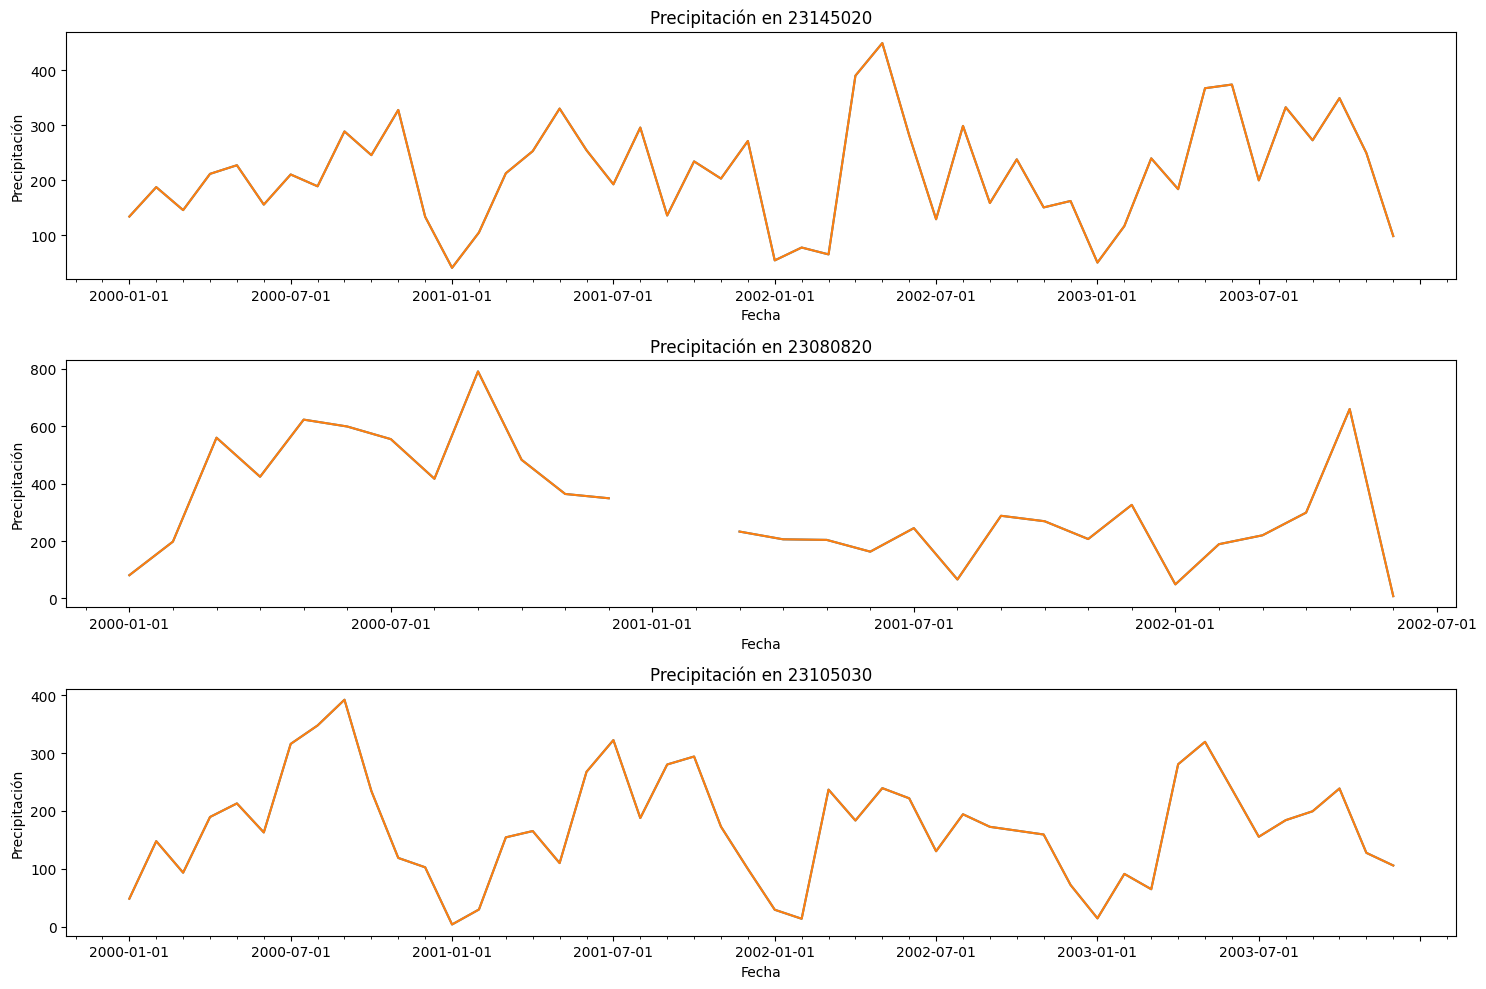

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

for ax, df, station in zip(axs, dfs, stations):
    ax.plot(df['Fecha'][0:48], df[station][0:48])
    ax.plot(df['Fecha'][0:48], df[station][0:48])
    ax.set_title(f'Precipitación en {station}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precipitación')
    ax.xaxis.set_major_locator(plt.MultipleLocator(6))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))


plt.tight_layout()
plt.show()

Visualmente podemos apreciar como si se ve una tendencia estacional que se repite cada 12 datos(es decir cada año), pero igualmente le pasamos una Prueba de Dickey-Fuller Aumentada (ADF) utilizando la libreria statsmodels

In [5]:
! pip install statsmodels
! pip install pmdarima

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.6 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.6/60.6 kB 1.6 MB/s eta 0:00:00
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB 9.9 MB/s eta 0:00:01
   -- ------------------------------------- 0.7/9.8 MB 9.3 MB/s eta 0:00:01
   ----- ---------------------------------- 1.2/9.8 MB 9.9 MB/s eta 0:00:01
   ------- -------------------------------- 1.8/9.8 MB 10.2 MB/s eta 0:00:01
   --------- ------------------------------ 2.3/9.8 MB 10.4 MB/s eta 0:00:01
   ---------- ----------------------------- 2.7/9.8 MB 10.1 MB/s eta 0:00:01
   ------------ --------------------------- 3.2/9.8 MB 10.1 MB/s eta 0:00:01
   -------------- ------------------------- 3.6/9.8 MB 9.9 MB/s eta 0:00:01
   ---------------- -

In [25]:
from statsmodels.tsa.stattools import adfuller

# Tomamos el primer dataframe de ejemplo
result = adfuller(dfs[0][stations[0]].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.794968580872568
p-value: 0.002959214531829239
Critial Values:
   1%, -3.4602906385073884
Critial Values:
   5%, -2.874708679520702
Critial Values:
   10%, -2.573788599127782


Dados los valores que encontramos, ADF es más negativa que todos los valores críticos (tanto al 1%, 5% y 10%) y un el valor p es extremadamente bajo, podemos concluir que la serie de tiempo es estacionaria, razon por la cual no necesitamos diferenciación y por lo mismo podemos asignar el valor 0 al término D del modelo ARIMA.

En este punto encontramos la funcionalidad de auto_arima que permite encontrar los mejores coeficientes a utilizar para la generación de los modelos. Al tener informacion anual que repite su estacionalidad, marcamos estos valores en la entrada, es decir el parametro seasonal en 'True' y m = 12. El parametro trace lo dejamos tambien en True para obervar como realiza la busqueda. Probremos unicamente con el primer dataframe, pero ya que necesitamos que nuestra serie de tiempo sea continua, eliminaremos los meses que tienen datos nulos.

In [28]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pmdarima import auto_arima

df_ARIMA = dfs[0].copy().dropna()

print(df_ARIMA.shape)

model = auto_arima(df_ARIMA[stations[0]], seasonal=True, m=12, trace=True)

(237, 4)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2864.688, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2809.462, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2818.837, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3266.200, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2842.551, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2803.218, Time=1.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2810.043, Time=1.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2806.287, Time=1.07 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2804.828, Time=1.73 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=2806.329, Time=0.94 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2802.921, Time=0.57 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2808.863, Time=0.21 sec
 ARIMA(0,0,1)(2,0,1)

In [29]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  237
Model:             SARIMAX(0, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1396.461
Date:                             Wed, 26 Jun 2024   AIC                           2802.921
Time:                                     10:01:22   BIC                           2820.261
Sample:                                          0   HQIC                          2809.910
                                             - 237                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    104.1929     18.097      5.757      0.000      68.723     139.663
ma.L1          0.1602      

In [30]:
# Obtenemos los valores de p, d, q, P, D y Q
p_value = model.order[0]
d_value = model.order[1]
q_value = model.order[2]
P_value = model.seasonal_order[0]
D_value = model.seasonal_order[1]
Q_value = model.seasonal_order[2]

print(f'El valor p sugerido es: {p_value}')
print(f'El valor d sugerido es: {d_value}')
print(f'El valor q sugerido es: {q_value}')
print(f'El valor P sugerido es: {P_value}')
print(f'El valor D sugerido es: {D_value}')
print(f'El valor Q sugerido es: {Q_value}')

El valor p sugerido es: 0
El valor d sugerido es: 0
El valor q sugerido es: 1
El valor P sugerido es: 2
El valor D sugerido es: 0
El valor Q sugerido es: 0


Entrenamos el modelo y procedemos a realizar la imputacion de los valores faltantes en la serie de tiempo, todavia eliminando los nulos de nuestro conjunto de datos inicial.

In [32]:
# Ajustamos el modelo ARIMA con los 6 valores encontrados
model = ARIMA(df_ARIMA[stations[0]], order=(p_value, d_value, q_value), seasonal_order=(P_value, D_value, Q_value, 12))
model_fit = model.fit()

c:\Users\nlmal\OneDrive - Universidad de La Rioja\Documentos\Master\Trabajo Fin de Master\HomogenizacionSeriesPrecipitacion\TFM\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nlmal\OneDrive - Universidad de La Rioja\Documentos\Master\Trabajo Fin de Master\HomogenizacionSeriesPrecipitacion\TFM\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nlmal\OneDrive - Universidad de La Rioja\Documentos\Master\Trabajo Fin de Master\HomogenizacionSeriesPrecipitacion\TFM\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
df_n = dfs[0].copy()
station = stations[0]
# Preparar los datos
df_n['Fecha'] = pd.to_datetime(df_n['Fecha'])

# Entrenar el modelo ARIMA con los datos no nulos
model = ARIMA(df_n[station].dropna(), order=(p_value, d_value, q_value))
model_fit = model.fit()

# Crear una copia del DataFrame original para no modificar los datos originales
df_fill = df_n.copy()

# Usar el modelo entrenado para predecir los valores nulos
for i in df_fill[df_fill[station].isna()].index:
    df_fill.loc[i, station] = model_fit.predict(start=i, end=i).values[0]

c:\Users\nlmal\OneDrive - Universidad de La Rioja\Documentos\Master\Trabajo Fin de Master\HomogenizacionSeriesPrecipitacion\TFM\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nlmal\OneDrive - Universidad de La Rioja\Documentos\Master\Trabajo Fin de Master\HomogenizacionSeriesPrecipitacion\TFM\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nlmal\OneDrive - Universidad de La Rioja\Documentos\Master\Trabajo Fin de Master\HomogenizacionSeriesPrecipitacion\TFM\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


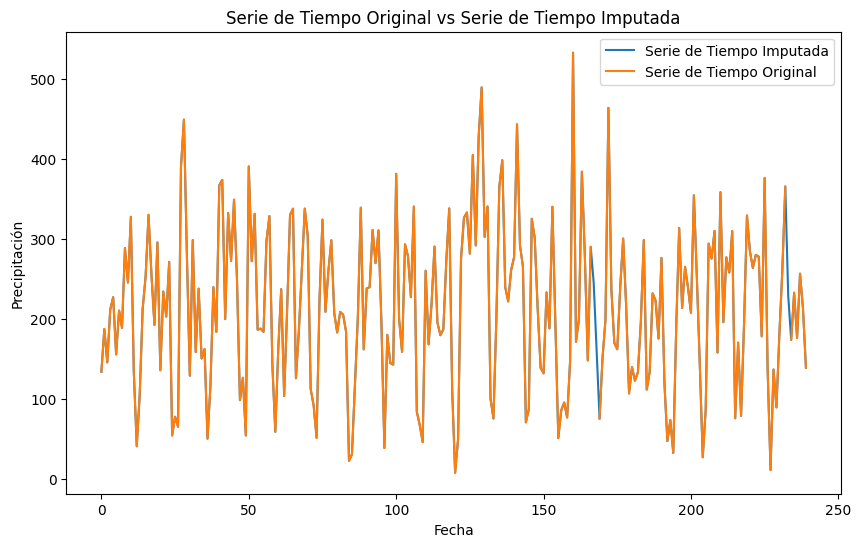

In [36]:
# seteamos el indice de la serie de tiempo
df_filled = df_fill.copy()
# utilizamos los datos originales para ver mejor los datos imputados
# para ello tomamos el dataframe original y renombramos la columna de precipitación
df_orig = dfs[0].copy()
df_orig = df_orig.rename(columns={station: 'Precipitación_original'})
df_orig = df_orig[['Precipitación_original']]

df_filled = df_filled.rename(columns={station: 'Precipitación_imputada'})

# cruzamos los datos originales con los datos imputados con join por fecha
df_filled = df_filled.join(df_orig, how='left')
df_filled

# Graficamos la serie de tiempo original y la serie de tiempo imputada, imprimos con los indices en als etiquetas rotados 90 grados
plt.figure(figsize=(10, 6))
plt.plot(df_filled['Precipitación_imputada'], label='Serie de Tiempo Imputada')
plt.plot(df_filled['Precipitación_original'], label='Serie de Tiempo Original')
plt.title('Serie de Tiempo Original vs Serie de Tiempo Imputada')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')

plt.legend()
plt.show()

Podemos observar como con el modelo ARIMA predecimos los datos faltantes de nuestra serie de tiempo para poder trabajar con ella mas adelante.

In [37]:
# contamos valores nulos en nuestro dataframe
print(df_filled.isnull().sum())

Fecha                     0
Mes                       0
Año                       0
Precipitación_imputada    0
Precipitación_original    3
dtype: int64


In [38]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               23145020   No. Observations:                  237
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1417.669
Date:                Wed, 26 Jun 2024   AIC                           2841.338
Time:                        10:04:00   BIC                           2851.742
Sample:                             0   HQIC                          2845.531
                                - 237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        214.1509      8.409     25.466      0.000     197.669     230.633
ma.L1          0.3145      0.061      5.149      0.000       0.195       0.434
sigma2      9182.4507    905.797     10.137      0.0

Procedemos a generar el codigo que se en cargue de tratar la imputacion de valores pero teniendo en cuenta diferentes metodologias previas a realizar el entrenamiento de los modelos ARIMA.

In [47]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import shutil
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Cargamos los datos
path = '../datos/separados_por_estacion/MAGDALENA_MEDIO/'

# Generamos un entero aletorio entre la cantidad total de estaciones
count_stations = os.listdir(path)

np.random.seed(1)
files = np.random.choice(count_stations, 3, replace=False)

stations = [s.split('.')[0] for s in files]
dfs = [pd.read_csv(path+file) for file in files]

Se hace la claridad que por el momento, el modelo esta generandose con la serie de tiempo discontinua, al eliminar los valores nulos, proceso que es necesario para el entrenamiento del modelo.

Estacion: 23145020


Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

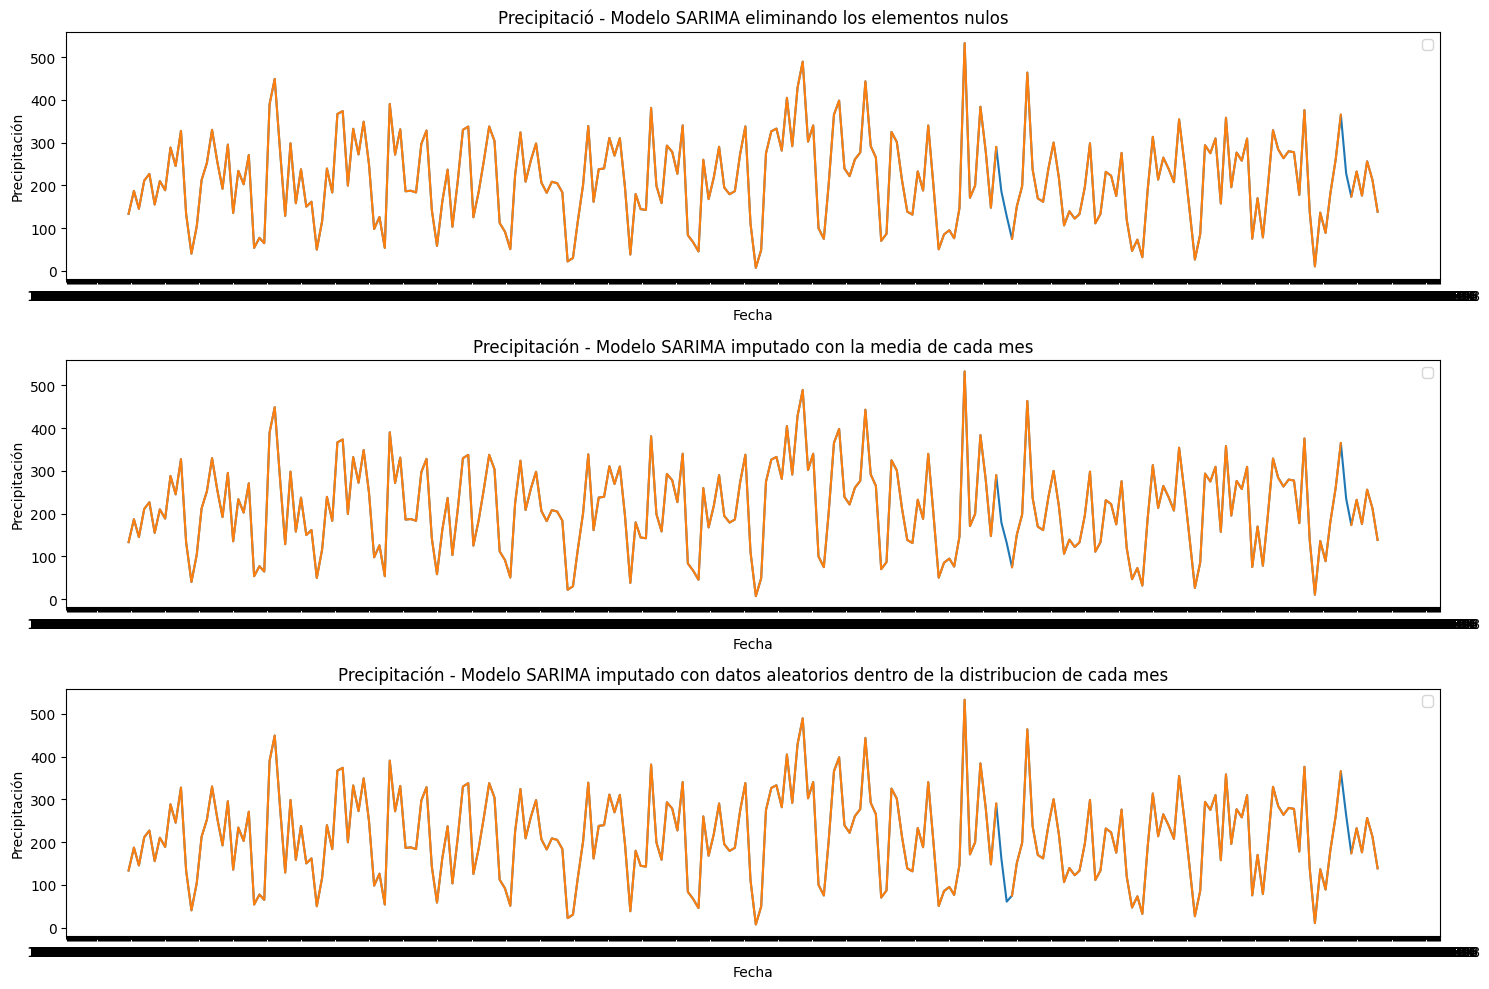

Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

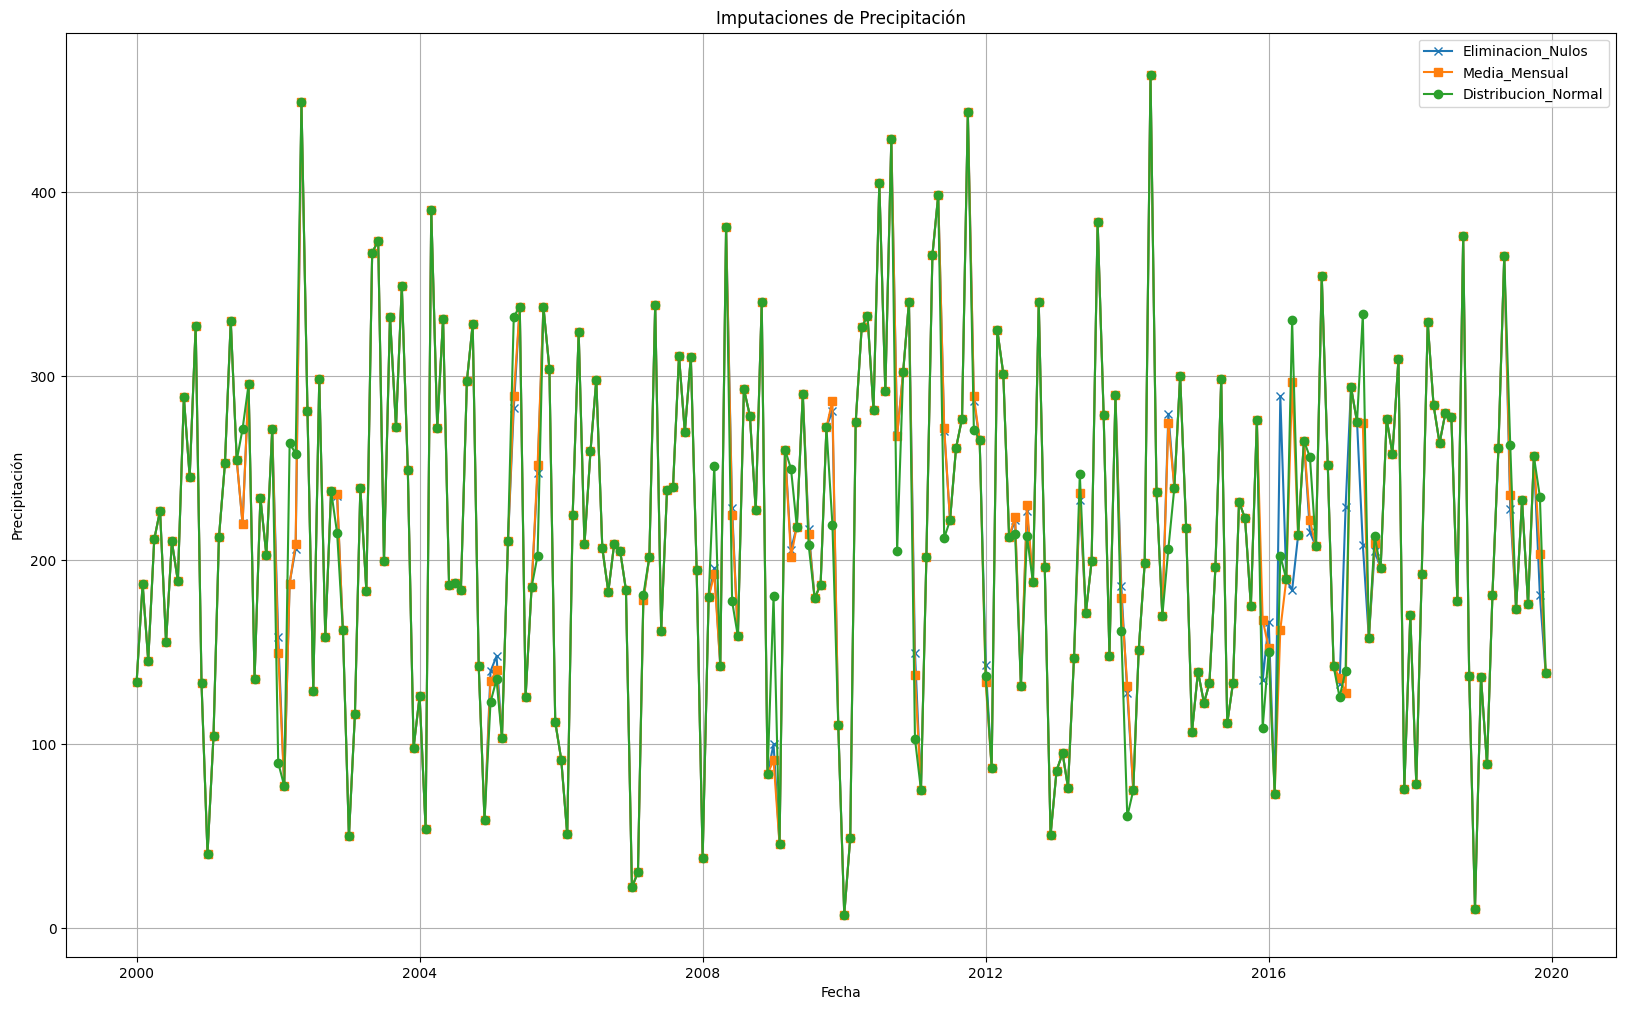

RMSE Eliminacion de Nulos: 42.35629350387941
RMSE Media Mensual: 36.751414584074084
RMSE Distribucion Normal: 40.315577823304935
Estacion: 23080820


Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

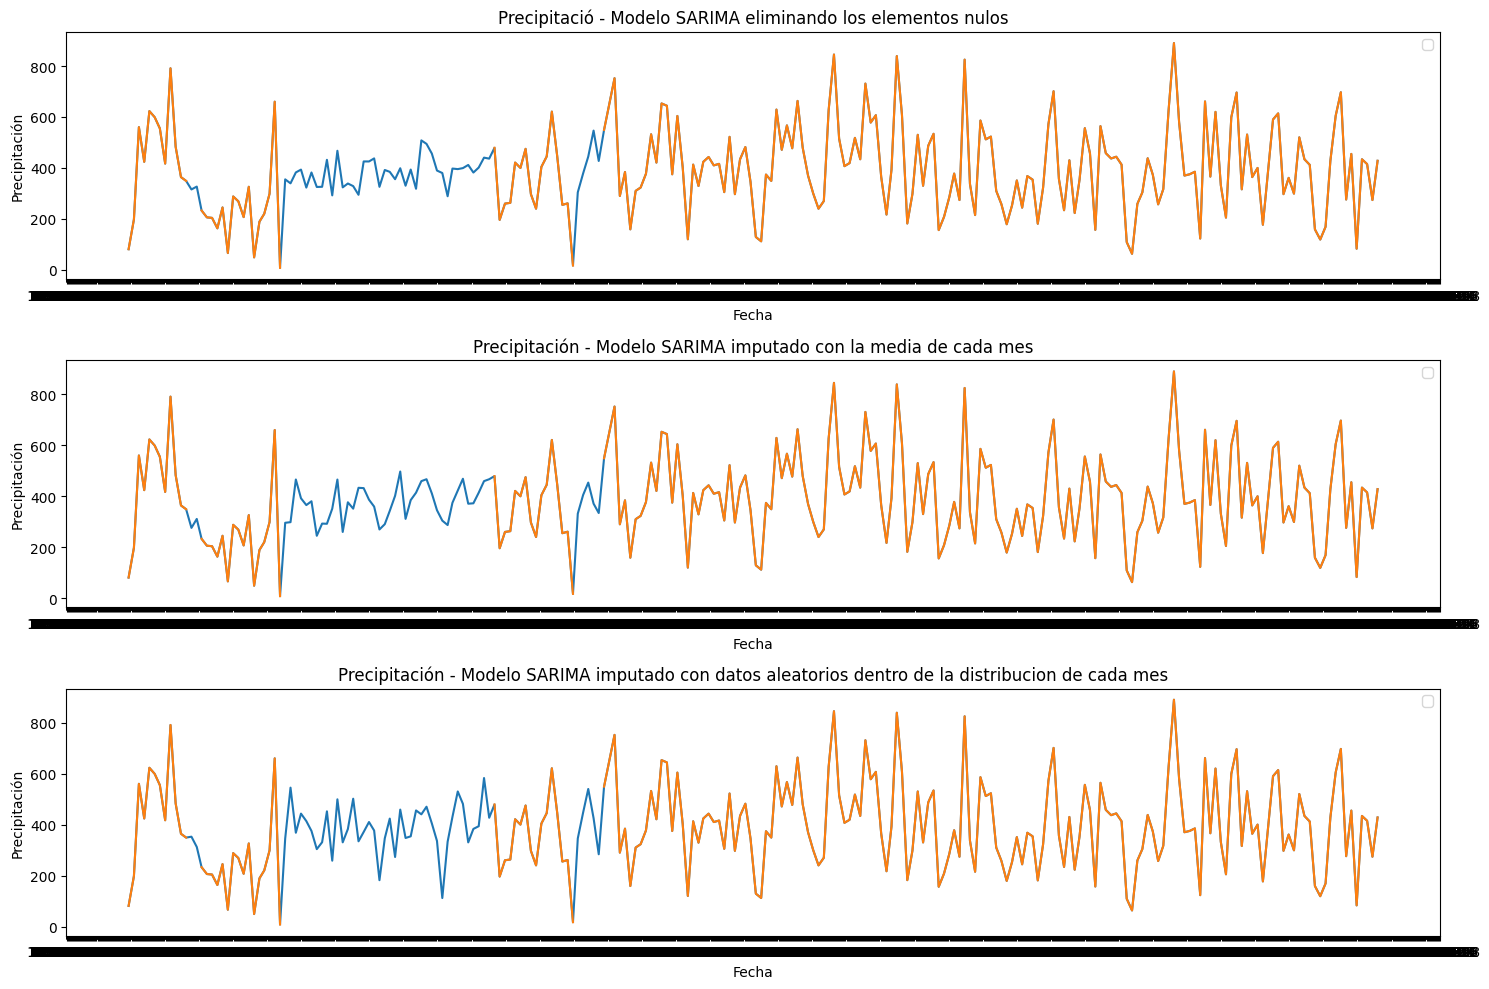

Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

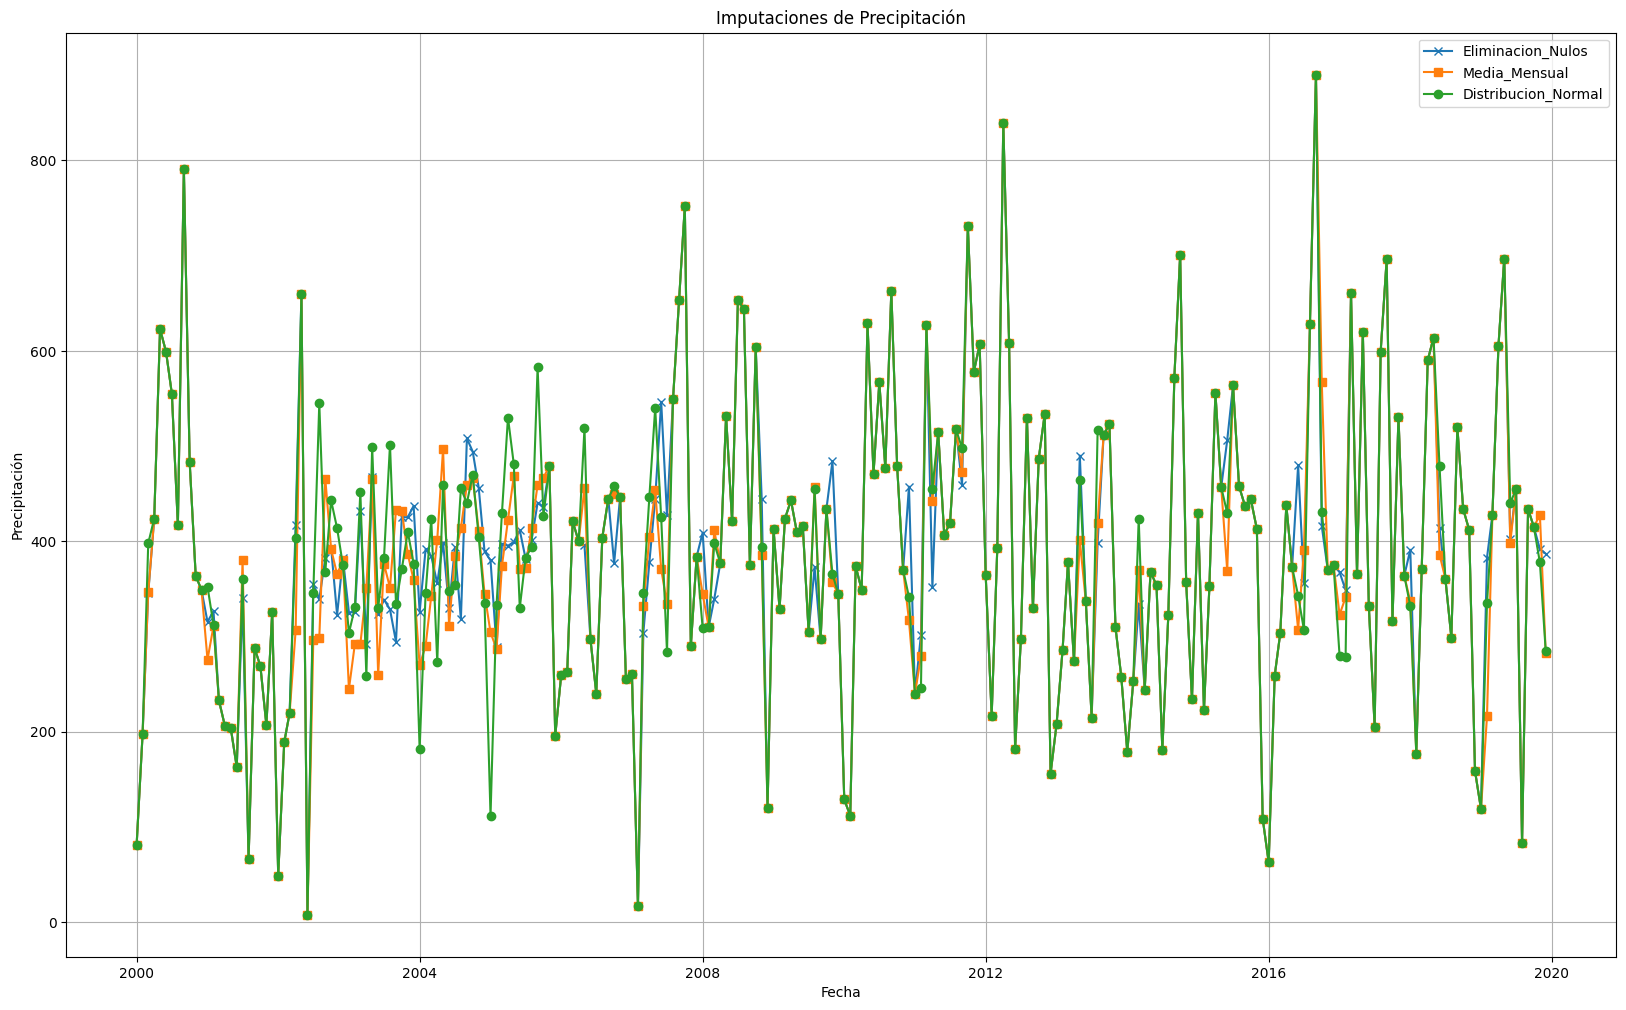

RMSE Eliminacion de Nulos: 71.32066302818355
RMSE Media Mensual: 60.50433447446154
RMSE Distribucion Normal: 59.64322324148613
Estacion: 23105030


Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

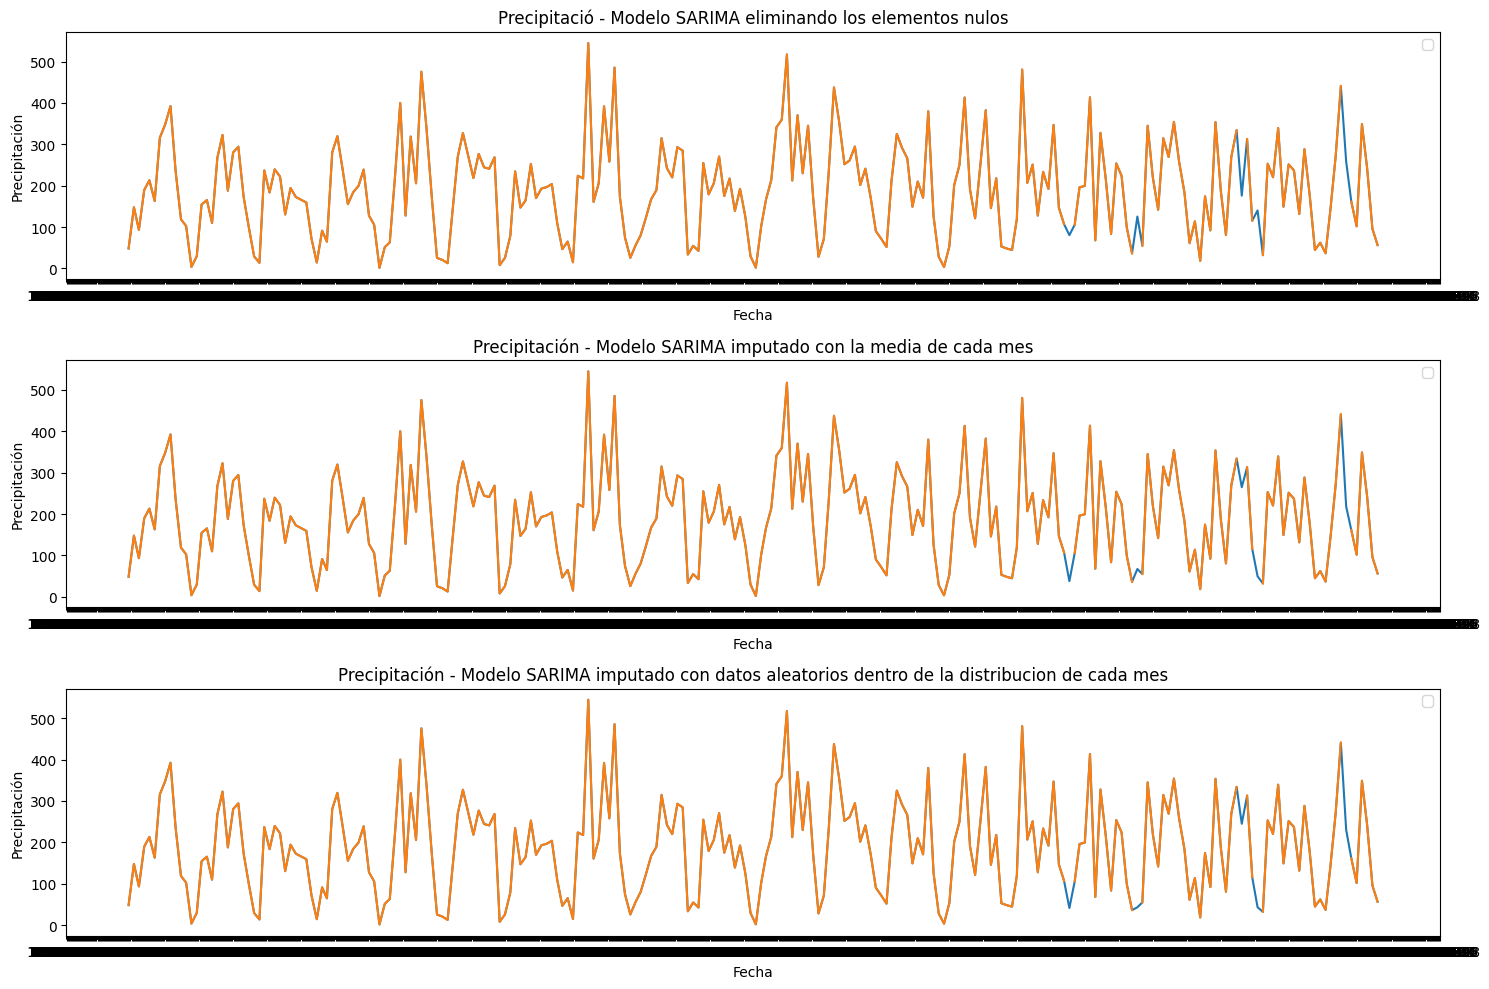

Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8003 ticks ([10593.0, ..., 18595.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1336 ticks ([10590.0, ..., 18600.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

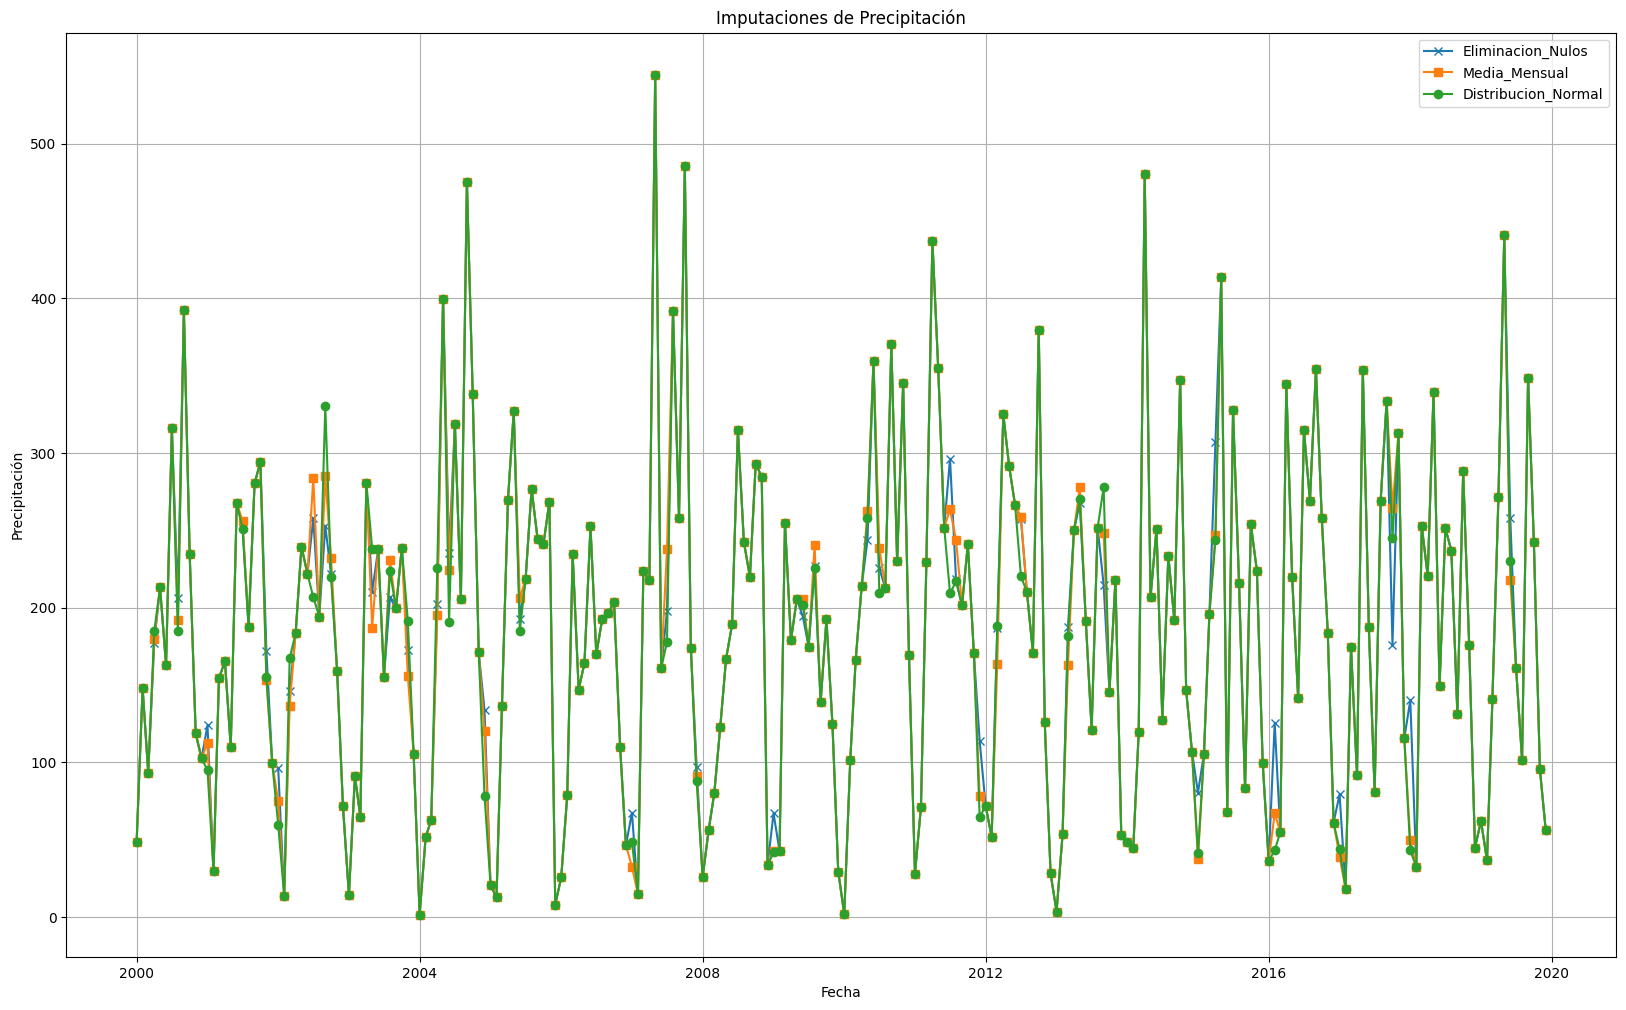

RMSE Eliminacion de Nulos: 36.091508563599874
RMSE Media Mensual: 35.19444090019449
RMSE Distribucion Normal: 33.77309187058009


In [59]:
results = []
summaries = []
rmse = []

for df, station in zip(dfs, stations):
    print('Estacion:', station)

    df_ARIMA = df.copy()

    df_ARIMA['Fecha'] = pd.to_datetime(df_ARIMA['Fecha'])
        
    # Llenamos el dataframe imputando los valores con al media de cada mas, para posteriormente entrenar el modelo y finalmente predecir los valores en los nulos de la serie de tiempo original.
    # Imputación usando la media mensual
    df_ARIMA['Precipitacion_Medias'] = df_ARIMA[station]
    months = df_ARIMA['Mes'].unique()
    for i in months:
        mean_month = df_ARIMA.loc[df_ARIMA['Mes']==i]['Precipitacion_Medias'].mean()
        df_ARIMA.loc[df_ARIMA['Mes']==i, 'Precipitacion_Medias'] = df_ARIMA.loc[df_ARIMA['Mes']==i, 'Precipitacion_Medias'].fillna(mean_month)
    
    df_ARIMA['Precipitacion_Normal'] = df_ARIMA[station]
    months = df_ARIMA['Mes'].unique()
    for i in months:
        mean_month = df_ARIMA.loc[df_ARIMA['Mes']==i]['Precipitacion_Normal'].mean()
        std_month = df_ARIMA.loc[df_ARIMA['Mes'] == i]['Precipitacion_Normal'].std()

        nulls_month = df_ARIMA[df_ARIMA['Mes']==i].isna().index

        vals_generated = np.random.normal(loc=mean_month, scale=std_month, size=len(nulls_month))
        for index, val in enumerate(nulls_month):
            df_ARIMA['Precipitacion_Normal'].iloc[val] = vals_generated[index]

    results.append([adfuller(df_ARIMA[station].dropna()), adfuller(df_ARIMA['Precipitacion_Medias']), adfuller(df_ARIMA['Precipitacion_Normal'])])

    output_models = '../RecursosYDocumentos/SARIMA/'
    

    model_1 = auto_arima(df_ARIMA[station].dropna(), seasonal=True, m=12, trace=False)
    # Ajustamos el modelo ARIMA con los 6 valores encontrados
    model_1 = ARIMA(df_ARIMA[station].dropna(), order=(model_1.order[0], model_1.order[1], model_1.order[2]), seasonal_order=(model_1.seasonal_order[0], model_1.seasonal_order[1], model_1.seasonal_order[2], 12))
    model_fit_1 = model_1.fit()
    

    model_2 = auto_arima(df_ARIMA['Precipitacion_Medias'], seasonal=True, m=12, trace=False)
    model_2 = ARIMA(df_ARIMA['Precipitacion_Medias'], order=(model_2.order[0], model_2.order[1], model_2.order[2]), seasonal_order=(model_2.seasonal_order[0], model_2.seasonal_order[1], model_2.seasonal_order[2], 12))
    model_fit_2 = model_2.fit()

    model_3 = auto_arima(df_ARIMA['Precipitacion_Normal'], seasonal=True, m=12, trace=False)
    model_3 = ARIMA(df_ARIMA['Precipitacion_Normal'], order=(model_3.order[0], model_3.order[1], model_3.order[2]), seasonal_order=(model_3.seasonal_order[0], model_3.seasonal_order[1], model_3.seasonal_order[2], 12))
    model_fit_3 = model_3.fit()

    summaries.append([model_fit_1.summary(), model_fit_2.summary(), model_fit_3.summary()])

    df_ARIMA["Precipitacion_Eliminacion"] = df_ARIMA[station]
    df_ARIMA["Precipitacion_Medias"] = df_ARIMA[station]
    df_ARIMA["Precipitacion_Normal"] = df_ARIMA[station]

    # Usar el modelo entrenado para predecir los valores nulos
    for i in df_ARIMA[df_ARIMA["Precipitacion_Eliminacion"].isna()].index:
        df_ARIMA.loc[i, "Precipitacion_Eliminacion"] = model_fit_1.predict(start=i, end=i).values[0]
        df_ARIMA.loc[i, "Precipitacion_Medias"] = model_fit_2.predict(start=i, end=i).values[0]
        df_ARIMA.loc[i, "Precipitacion_Normal"] = model_fit_3.predict(start=i, end=i).values[0]

    df_ARIMA = df_ARIMA.rename(columns={station: 'Precipitacion_Original'})

    # Graficamos la serie de tiempo original y cada una de las series de tiempo imputadas, imprimimos con los indices en las etiquetas rotados 90 grados
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    axs[0].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Eliminacion'])
    axs[0].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Original'])
    axs[0].set_title('Precipitació - Modelo SARIMA eliminando los elementos nulos')
    axs[0].set_xlabel('Fecha')
    axs[0].set_ylabel('Precipitación')
    axs[0].xaxis.set_major_locator(plt.MultipleLocator(6))
    axs[0].xaxis.set_minor_locator(plt.MultipleLocator(1))
    axs[0].legend()

    axs[1].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Medias'])
    axs[1].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Original'])
    axs[1].set_title('Precipitación - Modelo SARIMA imputado con la media de cada mes')
    axs[1].set_xlabel('Fecha')
    axs[1].set_ylabel('Precipitación')
    axs[1].xaxis.set_major_locator(plt.MultipleLocator(6))
    axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
    axs[1].legend()

    axs[2].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Normal'])
    axs[2].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Original'])
    axs[2].set_title('Precipitación - Modelo SARIMA imputado con datos aleatorios dentro de la distribucion de cada mes')
    axs[2].set_xlabel('Fecha')
    axs[2].set_ylabel('Precipitación')
    axs[2].xaxis.set_major_locator(plt.MultipleLocator(6))
    axs[2].xaxis.set_minor_locator(plt.MultipleLocator(1))
    axs[2].legend()

    plt.tight_layout()
    plt.show()
    plt.close()

    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    axs[0].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Eliminacion'])
    axs[0].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Original'])
    axs[0].set_title('Precipitació - Modelo SARIMA eliminando los elementos nulos')
    axs[0].set_xlabel('Fecha')
    axs[0].set_ylabel('Precipitación')
    axs[0].xaxis.set_major_locator(plt.MultipleLocator(6))
    axs[0].xaxis.set_minor_locator(plt.MultipleLocator(1))
    axs[0].legend()

    axs[1].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Medias'])
    axs[1].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Original'])
    axs[1].set_title('Precipitación - Modelo SARIMA imputado con la media de cada mes')
    axs[1].set_xlabel('Fecha')
    axs[1].set_ylabel('Precipitación')
    axs[1].xaxis.set_major_locator(plt.MultipleLocator(6))
    axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
    axs[1].legend()

    axs[2].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Normal'])
    axs[2].plot(df_ARIMA['Fecha'], df_ARIMA['Precipitacion_Original'])
    axs[2].set_title('Precipitación - Modelo SARIMA imputado con datos aleatorios dentro de la distribucion de cada mes')
    axs[2].set_xlabel('Fecha')
    axs[2].set_ylabel('Precipitación')
    axs[2].xaxis.set_major_locator(plt.MultipleLocator(6))
    axs[2].xaxis.set_minor_locator(plt.MultipleLocator(1))
    axs[2].legend()

    plt.tight_layout()
    plt.savefig(output_models + station + '_imputada.png')
    plt.close()

    df_2 = df_ARIMA[['Fecha', 'Precipitacion_Original', 'Precipitacion_Eliminacion', 'Precipitacion_Medias', 'Precipitacion_Normal']]

    # eliminamos valores aleatorios para probar la imputación con las diferentes técnicas, para ello creamos una nueva columna con los valores originales y dejamos en NaN el 10% de los valores
    df_2['Precipitacion_Original_2'] = df_2['Precipitacion_Original']
    df_2['Precipitacion_Original_2'] = df_2['Precipitacion_Original_2'].sample(frac=0.85)
    df_2['Precipitacion_SARIMA_Eliminacion'] = df_2['Precipitacion_Original_2']
    df_2['Precipitacion_SARIMA_Medias'] = df_2['Precipitacion_Original_2']
    df_2['Precipitacion_SARIMA_Normal'] = df_2['Precipitacion_Original_2']

    # Usar el modelo entrenado para predecir los valores nulos
    for i in df_2[df_2['Precipitacion_Original_2'].isna()].index:
        df_2.loc[i, 'Precipitacion_SARIMA_Eliminacion'] = model_fit_1.predict(start=i, end=i).values[0]
        df_2.loc[i, 'Precipitacion_SARIMA_Medias'] = model_fit_2.predict(start=i, end=i).values[0]
        df_2.loc[i, 'Precipitacion_SARIMA_Normal'] = model_fit_3.predict(start=i, end=i).values[0]

    # # Graficar los datos originales y los datos interpolados, graficamos unicamente los datos de los indices 180 a 225
    plt.figure(figsize=(20, 12))
    plt.plot(df_2["Fecha"], df_2['Precipitacion_SARIMA_Eliminacion'], label='Eliminacion_Nulos', marker='x')
    plt.plot(df_2["Fecha"], df_2['Precipitacion_SARIMA_Medias'], label='Media_Mensual', marker='s')
    plt.plot(df_2["Fecha"], df_2['Precipitacion_SARIMA_Normal'], label='Distribucion_Normal', marker='o')
    plt.title('Imputaciones de Precipitación')
    plt.xlabel('Fecha')
    plt.ylabel('Precipitación')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_models + station + '_tests_sarima.png')
    plt.close()

    # # Graficar los datos originales y los datos interpolados, graficamos unicamente los datos de los indices 180 a 225
    plt.figure(figsize=(20, 12))
    plt.plot(df_2["Fecha"], df_2['Precipitacion_SARIMA_Eliminacion'], label='Eliminacion_Nulos', marker='x')
    plt.plot(df_2["Fecha"], df_2['Precipitacion_SARIMA_Medias'], label='Media_Mensual', marker='s')
    plt.plot(df_2["Fecha"], df_2['Precipitacion_SARIMA_Normal'], label='Distribucion_Normal', marker='o')
    plt.title('Imputaciones de Precipitación')
    plt.xlabel('Fecha')
    plt.ylabel('Precipitación')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    # Eliminamos todos los nulos de la columna original
    df_2 = df_2.dropna(subset=['Precipitacion_Original'])

    rmse_media = sqrt(mean_squared_error(df_2['Precipitacion_Original'], df_2['Precipitacion_SARIMA_Eliminacion']))
    rmse_interpolacion = sqrt(mean_squared_error(df_2['Precipitacion_Original'], df_2['Precipitacion_SARIMA_Medias']))
    rmse_sarima = sqrt(mean_squared_error(df_2['Precipitacion_Original'], df_2['Precipitacion_SARIMA_Normal']))

    print('RMSE Eliminacion de Nulos:', rmse_media)
    print('RMSE Media Mensual:', rmse_interpolacion)
    print('RMSE Distribucion Normal:', rmse_sarima)
    rmse.append([rmse_media, rmse_interpolacion, rmse_sarima])

In [63]:
# Creamos un dataframe con los resultados
df_results = pd.DataFrame(results, columns=['ADF_Original', 'ADF_Medias', 'ADF_Normal'])
df_results['Estacion'] = stations
df_results['RMSE_Eliminacion'] = [r[0] for r in rmse]
df_results['RMSE_Medias'] = [r[1] for r in rmse]
df_results['RMSE_Normal'] = [r[2] for r in rmse]
df_results['Summary_Original'] = [s[0] for s in summaries]

df_results.to_csv('../RecursosYDocumentos/SARIMA/Resultados_SARIMA.csv', index=False, sep='|')

In [64]:
# Revisamos cual es la tecnica con menor RMSE para las 3 estaciones comparando las 3 columnas
df_results['RMSE_Eliminacion'] = df_results['RMSE_Eliminacion'].astype(float)
df_results['RMSE_Medias'] = df_results['RMSE_Medias'].astype(float)
df_results['RMSE_Normal'] = df_results['RMSE_Normal'].astype(float)

df_results['Min_RMSE'] = df_results[['RMSE_Eliminacion', 'RMSE_Medias', 'RMSE_Normal']].idxmin(axis=1)
df_results['Min_RMSE'] = df_results['Min_RMSE'].replace({'RMSE_Eliminacion': 'Eliminacion', 'RMSE_Medias': 'Medias', 'RMSE_Normal': 'Normal'})

df_results

,ADF_Original,ADF_Medias,ADF_Normal,Estacion,RMSE_Eliminacion,RMSE_Medias,RMSE_Normal,Summary_Original,Min_RMSE
0,"(-3.794968580872568, 0.002959214531829239, 15,...","(-3.7824024312002344, 0.0030925808295934293, 1...","(-3.532917685228345, 0.007180865334496816, 14,...",23145020,42.356294,36.751415,40.315578,SARIMAX R...,Medias
1,"(-2.8515055215461613, 0.0512848560873834, 15, ...","(-3.9026623514159318, 0.002015340797954328, 14...","(-3.661283008846443, 0.004691902301309946, 14,...",23080820,71.320663,60.504334,59.643223,SARIMAX Re...,Normal
2,"(-4.624572896526369, 0.00011634845178252036, 1...","(-4.565439941308718, 0.0001495016348404721, 15...","(-3.291799773141827, 0.015249027728571672, 12,...",23105030,36.091509,35.194441,33.773092,SARIMAX...,Normal


Observamos como el resultado con menor RMSE en 2 de las 3 estaciones escogidas es el de imputar con la distribución normal, entrenar el modelo ARIMA y finalmente imputar los valores faltantes originales. Sin embargo, se observa que imputar los datos por medio de utilizar la media estan bastante cerca y son mejores en una de las estaciones.